In [23]:
import matplotlib
import sklearn
from sklearn import metrics
import time
import torch
import torchvision

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
training_data_directory = "/content/drive/MyDrive/HTCV/grouped-data/train/"
testing_data_directory = "/content/drive/MyDrive/HTCV/grouped-data/test/"
model_name = "/content/drive/MyDrive/HTCV//resnet_18.pth"

In [12]:
training_data_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        training_data_directory,
        torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
                ),
            ]
        ),
    ),
    batch_size=12,
    shuffle=True,
    num_workers=8,
)

testing_data = torchvision.datasets.ImageFolder(
    testing_data_directory,
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
)
testing_data_loader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=12,
    shuffle=False,
    num_workers=8,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
print("Training dataset size:", len(training_data_loader.dataset))
print("Testing dataset size:", len(testing_data_loader.dataset))
print("Class names:", training_data_loader.dataset.classes)

Training dataset size: 2799
Testing dataset size: 933
Class names: ['0', '1', '2', '3', '4']


In [14]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
input_feature_count = model.fc.in_features
output_feature_count = 5
model.fc = torch.nn.Linear(input_feature_count, output_feature_count)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 367MB/s]


In [15]:
def format_duration(seconds):
    # Calculate the time components
    components = [
        ("w", seconds // 604800),  # 1 week is 604800 seconds
        ("d", seconds // 86400 % 7),  # 1 day is 86400 seconds
        ("h", seconds // 3600 % 24),  # 1 hour is 3600 seconds
        ("min", seconds // 60 % 60),  # 1 minute is 60 seconds
        ("s", round(seconds % 60, 2)),
    ]

    # Only include non-zero components
    components = [(label, value) for label, value in components if value > 0]

    # Format the string
    return ", ".join(f"{value}{label}" for label, value in components)


def print_phase_info(is_training, total_loss, correct_prediction_count):
    dataset_length = len(
        training_data_loader.dataset if is_training else testing_data_loader.dataset
    )
    print(
        "    {} Epoch {} done. Loss: {:.2f}, Accuracy: {:.2f}%, Phase Duration: {}, Total Duration: {}".format(
            "Training" if is_training else "Testing",
            epoch,
            total_loss / dataset_length,
            (correct_prediction_count / dataset_length) * 100.0,
            format_duration(time.time() - (training_start_time if is_training else testing_start_time)),
            format_duration(time.time() - start_time),
        )
    )


epoch_count = 2
start_time = time.time()
for epoch in range(epoch_count):
    epoch_start_time = time.time()
    print("Epoch {} running.".format(epoch))
    """ Training Phase """
    training_start_time = time.time()
    model.train()
    total_loss = 0.0
    correct_prediction_count = 0
    for inputs, targets in training_data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Foward pass
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, targets)

        # Back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct_prediction_count += torch.sum(predictions == targets.data)
    print_phase_info(True, total_loss, correct_prediction_count)

    """ Testing Phase """
    testing_start_time = time.time()
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        correct_prediction_count = 0
        for inputs, targets in testing_data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            correct_prediction_count += torch.sum(predictions == targets.data)
        print_phase_info(False, total_loss, correct_prediction_count)

    print(
        "Epoch {} done. Epoch Duration: {}, Total Duration: {}".format(
            epoch,
            format_duration(time.time() - epoch_start_time),
            format_duration(time.time() - start_time),
        )
    )
    print("--------------------------------------------")

Epoch 0 running.
    Training Epoch 0 done. Loss: 1.11, Accuracy: 55.73%, Phase Duration: 5.0min, 42.58s, Total Duration: 5.0min, 42.58s
    Testing Epoch 0 done. Loss: 0.85, Accuracy: 67.20%, Phase Duration: 1.0min, 54.47s, Total Duration: 7.0min, 37.05s
Epoch 0 done. Epoch Duration: 7.0min, 37.05s, Total Duration: 7.0min, 37.05s
--------------------------------------------
Epoch 1 running.
    Training Epoch 1 done. Loss: 0.76, Accuracy: 71.06%, Phase Duration: 1.0min, 48.69s, Total Duration: 9.0min, 25.74s
    Testing Epoch 1 done. Loss: 0.89, Accuracy: 66.99%, Phase Duration: 34.79s, Total Duration: 10.0min, 0.53s
Epoch 1 done. Epoch Duration: 2.0min, 23.48s, Total Duration: 10.0min, 0.54s
--------------------------------------------


In [20]:
torch.save(model.state_dict(), model_name)

In [21]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
input_feature_count = model.fc.in_features
output_feature_count = 5
model.fc = torch.nn.Linear(input_feature_count, output_feature_count)
model.load_state_dict(torch.load(model_name))
model = model.to(device)

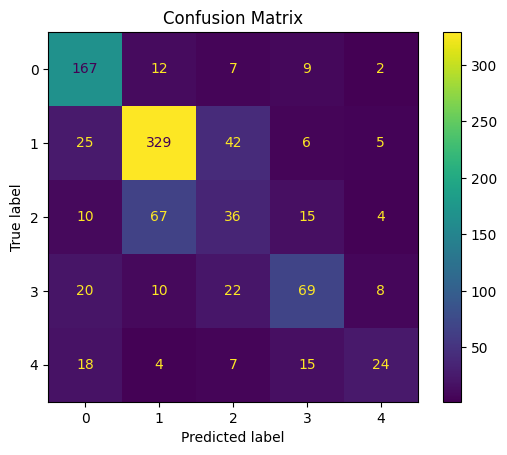

Overall accuracy: 66.99%
Average accuracy: 56.33%


In [25]:
model.eval()
with torch.no_grad():
    inputs, targets = next(
        iter(
            torch.utils.data.DataLoader(
                testing_data,
                batch_size=len(testing_data),
            )
        )
    )
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    confusion_matrix = metrics.confusion_matrix(targets, predictions.cpu())
    overall_accuracy = confusion_matrix.trace() / confusion_matrix.sum()
    average_accuracy = (
        confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)
    ).mean()
    confusion_matrix_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix
    )
    confusion_matrix_display.plot()
    matplotlib.pyplot.title("Confusion Matrix")
    matplotlib.pyplot.show()
    print("Overall accuracy: {:.2f}%".format(overall_accuracy * 100))
    print("Average accuracy: {:.2f}%".format(average_accuracy * 100))